# Introduction

In [1]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.uni_bi_variate_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
from sklearn.preprocessing import LabelEncoder

import time
from sklearn import cluster, metrics
from sklearn.manifold import TSNE

import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

%matplotlib inline
low_memory=False # faible mémoire vive (RAM) pour gérer la lecture de gros fichiers

In [2]:
print('>>:', np.__version__)

>>: 1.21.4


# 1. Chargement & Nettoyage des Données

In [3]:
df = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv', low_memory=low_memory)

Le data set contient :
	- 1050 lignes et 15 colonnes.
	- 341 valeurs manquantes, ce qui représente 2.17 % du data set.
Voici un sous-échantillon aléatoire :


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
537,f242a2cf1525f7700770cf1262b4b660,2016-01-07 05:50:25 +0000,http://www.flipkart.com/maxima-01784bmly-gold-...,Maxima 01784BMLY Gold Analog Watch - For Women,"[""Watches >> Wrist Watches >> Maxima Wrist Wat...",WATDZ5HGF5UXGZVG,995.0,995.0,f242a2cf1525f7700770cf1262b4b660.jpg,True,Maxima 01784BMLY Gold Analog Watch - For Wome...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Other Dime..."
270,7ee2e665b7de2e1cc29e3c65bde0c318,2015-12-01 12:40:44 +0000,http://www.flipkart.com/mavi-237mbb-showpiece-...,Mavi 237MBB Showpiece - 15 cm,"[""Home Decor & Festive Needs >> Showpieces >> ...",SHIE7QCY6ZQSUF6E,3280.0,1290.0,7ee2e665b7de2e1cc29e3c65bde0c318.jpg,False,Buy Mavi 237MBB Showpiece - 15 cm for Rs.129...,No rating available,No rating available,Mavi,"{""product_specification""=>[{""key""=>""Brand"", ""v..."


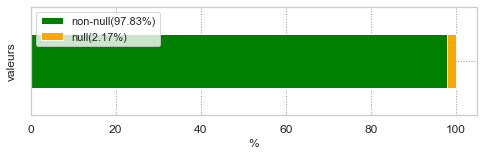

In [4]:
verifier_taille(df)
afficher_echantillon(df)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [6]:
doublons(df['product_name'])

Series([], Name: product_name, dtype: object)

In [7]:
afficher_echantillon(df['description'], n=3).tolist()

Voici un sous-échantillon aléatoire :


['Sonata 7085YL01 Analog Watch  - For Men - Buy Sonata 7085YL01 Analog Watch  - For Men  7085YL01 Online at Rs.750 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!',
 'Wild Stone Deodorant No-22 Combo Set (Set of 2)\r\n                         Price: Rs. 356\r\n\t\t\t\t\r\n\t\t\tLong lasting fragrance\r\nContains tricolosan as an active ingredient for deodorizing and long lasting fragrance\r\nLong lasting fragrance\r\nContains tricolosan as an active ingredient for deodorizing and long lasting fragrance']

In [8]:
df[['product_category_tree', 'product_name']].sort_values(by='product_category_tree').values

array([['["Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations >> Doraemon Gift Family Ceramic Coffee Mug Multicol..."]',
        'Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames >> Cocovey Photo Frames"]',
        'Cocovey Metal Photo Frame'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames >> Indha Craft Photo Frames"]',
        'Indha Craft Cloth Photo Frame'],
       ...,
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 149 Analog Watch  - For Girls, Women"]',
        'palito PLO 149 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 166 Analog Watch  - For Girls, Women"]',
        'palito PLO 166 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches >> palito PLO 169 Analog Watch  - For Girls, Women"]',
        'palito PLO

In [9]:
df['product_category_tree'] = df['product_category_tree'].apply(lambda x : ('>>'.join(x.split('>>')[:-1])).strip())

In [10]:
df[['product_category_tree', 'product_name']].sort_values(by='product_category_tree').values

array([['["Baby Care >> Baby & Kids Gifts >> Decorations >> Doraemon Gift Family Ceramic Coffee Mug Decorations',
        'Doraemon Gift Family Ceramic Coffee Mug Multicolour Mug - 325 ml'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames',
        'MH MDF Photo Frame'],
       ['["Baby Care >> Baby & Kids Gifts >> Photo Frames',
        'Indha Craft Cloth Photo Frame'],
       ...,
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 149 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 166 Analog Watch  - For Girls, Women'],
       ['["Watches >> Wrist Watches >> palito Wrist Watches',
        'palito PLO 169 Analog Watch  - For Girls, Women']], dtype=object)

## Nettoyage du texte

In [11]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Shadow\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [12]:
# Tokenizer
from nltk.tokenize import word_tokenize
import string
import re
# Stop words
from nltk.corpus import stopwords
from stop_words import get_stop_words #pip install stop-words
stop_w = list(set(stopwords.words('english')+get_stop_words('english')))

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2
    
def tokenizer_fct(sentence) :
    # Retirer les ponctuations
    punctuations = [p for p in string.punctuation]
    sentence_clean=sentence
    for p in punctuations:
        sentence_clean = sentence_clean.replace(p, ' ')
    # Retirer les nomres
    sentence_clean = re.sub('\d+', '', sentence_clean)
    # Tokinser la phrase nettoyée
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)    
    lw = lower_start_fct(word_tokens)
    lem_w = lemma_fct(lw)    
    sw = stop_word_filter_fct(lem_w)
    transf_desc_text = ' '.join(sw)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

## Compilation des descriptions en Corpus

In [13]:
corpus = ''
for description in df['description']:
    corpus += description + ' '

corpus = transform_bow_lem_fct(corpus).split()
len(corpus)

53489

In [14]:
print(corpus[:100])

['key', 'feature', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'floral', 'curtain', 'elegance', 'polyester', 'multicolor', 'abstract', 'eyelet', 'door', 'curtain', 'height', 'pack', 'price', 'curtain', 'enhances', 'look', 'interior', 'curtain', 'made', 'high', 'quality', 'polyester', 'fabric', 'feature', 'eyelet', 'style', 'stitch', 'metal', 'ring', 'make', 'room', 'environment', 'romantic', 'loving', 'curtain', 'ant', 'wrinkle', 'anti', 'shrinkage', 'elegant', 'apparance', 'give', 'home', 'bright', 'modernistic', 'appeal', 'design', 'surreal', 'attention', 'sure', 'steal', 'heart', 'contemporary', 'eyelet', 'valance', 'curtain', 'slide', 'smoothly', 'draw', 'apart', 'first', 'thing', 'morning', 'welcome', 'bright', 'sun', 'ray', 'want', 'wish', 'good', 'morning', 'whole', 'world', 'draw', 'close', 'evening', 'create', 'special', 'moment', 'joyous', 'beauty', 'given', 'soothing', 'print', 'bring', 'home', 'elegant', 'curtain', 'softly', 'filter', 'li

# Analyse des Fréquences

## MostCommons

In [15]:
fq = nltk.FreqDist(corpus)
fq

FreqDist({'product': 864, 'free': 618, 'buy': 581, 'delivery': 567, 'genuine': 564, 'shipping': 564, 'cash': 564, 'price': 561, 'replacement': 559, 'day': 553, ...})

In [16]:
print(fq.most_common(100))

[('product', 864), ('free', 618), ('buy', 581), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 561), ('replacement', 559), ('day', 553), ('flipkart', 481), ('com', 473), ('guarantee', 471), ('mug', 457), ('feature', 404), ('online', 396), ('specification', 379), ('color', 369), ('watch', 355), ('type', 325), ('baby', 321), ('pack', 319), ('material', 313), ('set', 312), ('cotton', 299), ('box', 297), ('general', 288), ('design', 273), ('package', 269), ('sale', 262), ('analog', 262), ('number', 254), ('warranty', 252), ('quality', 245), ('detail', 243), ('girl', 242), ('inch', 239), ('brand', 238), ('laptop', 236), ('best', 230), ('key', 228), ('model', 226), ('ceramic', 219), ('fabric', 211), ('showpiece', 207), ('size', 196), ('made', 189), ('great', 189), ('boy', 184), ('perfect', 184), ('gift', 183), ('india', 180), ('dimension', 177), ('men', 177), ('skin', 175), ('usb', 174), ('home', 170), ('ideal', 167), ('coffee', 164), ('multicolor', 160), ('

In [17]:
most_common_words = fq.most_common(38)
print(most_common_words)

[('product', 864), ('free', 618), ('buy', 581), ('delivery', 567), ('genuine', 564), ('shipping', 564), ('cash', 564), ('price', 561), ('replacement', 559), ('day', 553), ('flipkart', 481), ('com', 473), ('guarantee', 471), ('mug', 457), ('feature', 404), ('online', 396), ('specification', 379), ('color', 369), ('watch', 355), ('type', 325), ('baby', 321), ('pack', 319), ('material', 313), ('set', 312), ('cotton', 299), ('box', 297), ('general', 288), ('design', 273), ('package', 269), ('sale', 262), ('analog', 262), ('number', 254), ('warranty', 252), ('quality', 245), ('detail', 243), ('girl', 242), ('inch', 239), ('brand', 238)]


In [18]:
exclud_common = ['mug', 'watch', 'baby', 'cotton', 'girl']
most_common_words = [w for w,c in most_common_words if w not in exclud_common]
print(most_common_words)

['product', 'free', 'buy', 'delivery', 'genuine', 'shipping', 'cash', 'price', 'replacement', 'day', 'flipkart', 'com', 'guarantee', 'feature', 'online', 'specification', 'color', 'type', 'pack', 'material', 'set', 'box', 'general', 'design', 'package', 'sale', 'analog', 'number', 'warranty', 'quality', 'detail', 'inch', 'brand']


In [19]:
len(set(corpus))

4528

In [20]:
print(fq.most_common()[-200:])

[('junior', 1), ('cal', 1), ('bead', 1), ('workstation', 1), ('successful', 1), ('financial', 1), ('eventually', 1), ('wonder', 1), ('amnesia', 1), ('helping', 1), ('peacefully', 1), ('shoo', 1), ('bad', 1), ('dream', 1), ('nightmare', 1), ('bedside', 1), ('clearing', 1), ('programmed', 1), ('situation', 1), ('growth', 1), ('souvenir', 1), ('grinding', 1), ('pendulum', 1), ('applicable', 1), ('scene', 1), ('gfssp', 1), ('placket', 1), ('barrel', 1), ('cuff', 1), ('sits', 1), ('flushed', 1), ('pop', 1), ('cheek', 1), ('buildable', 1), ('applicator', 1), ('jali', 1), ('tblue', 1), ('tbtts', 1), ('aarika', 1), ('banded', 1), ('brocade', 1), ('patiala', 1), ('rishan', 1), ('rishak', 1), ('fsp', 1), ('restitch', 1), ('bundle', 1), ('joy', 1), ('alteration', 1), ('chino', 1), ('kgt', 1), ('seven', 1), ('twisting', 1), ('choclate', 1), ('revealed', 1), ('added', 1), ('revealing', 1), ('persnalized', 1), ('mail', 1), ('resultion', 1), ('ksrao', 1), ('gmail', 1), ('ounce', 1), ('tre', 1), ('wei

## Bag-of-Words: Count & TF-IDF

In [21]:
df_corpus = pd.DataFrame(df['product_name'].values, columns=['name'])
df_corpus['description'] = df['description'].apply(lambda s: ' '.join([w for w in transform_bow_lem_fct(s).split() if w not in most_common_words]))
df_corpus['categ'] = LabelEncoder().fit_transform(df['product_category_tree'])
df_corpus['categ'] = LabelEncoder().fit_transform(df['product_category_tree'].apply(lambda s: s.split('>>')[0]))
categs = df_corpus['categ'].values.tolist()
df_corpus

,name,description,categ
0,Elegance Polyester Multicolor Abstract Eyelet ...,key elegance polyester multicolor abstract eye...,6
1,Sathiyas Cotton Bath Towel,sathiyas cotton bath towel bath towel red yell...,0
2,Eurospa Cotton Terry Face Towel Set,key eurospa cotton terry face towel size small...,0
3,SANTOSH ROYAL FASHION Cotton Printed King size...,key santosh royal fashion cotton printed king ...,6
4,Jaipur Print Cotton Floral King sized Double B...,key jaipur print cotton floral king sized doub...,6
...,...,...,...
1045,Oren Empower Extra Large Self Adhesive Sticker,oren empower extra large self adhesive sticker...,0
1046,Wallmantra Large Vinyl Sticker Sticker,wallmantra large vinyl sticker sticker bring h...,0
1047,Uberlyfe Extra Large Pigmented Polyvinyl Films...,uberlyfe extra large pigmented polyvinyl film ...,0
1048,Wallmantra Medium Vinyl Sticker Sticker,wallmantra medium vinyl sticker sticker wallma...,0


In [22]:
print('Nombre de catégories:', len(df_corpus['categ'].unique()))

Nombre de catégories: 9


In [23]:
# création du bag of words (CountVectorizer et Tf-idf)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

feat = 'description'
ngram = (1,1)
cvect = CountVectorizer(max_df=0.95, ngram_range=ngram)
ctf = TfidfVectorizer(max_df=0.95, ngram_range=ngram)

count_bow = cvect.fit_transform(df_corpus[feat])
tfidf_bow = ctf.fit_transform(df_corpus[feat])

tfidf_bow_df=pd.DataFrame(tfidf_bow.toarray(), columns=sorted(list(cvect.vocabulary_)))

In [24]:
tfidf_bow_df

aaa  aapno  aari  aarika  ability  abkl  able  abode  abrasion  abroad  \
0     0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
1     0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
2     0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
3     0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
4     0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
...   ...    ...   ...     ...      ...   ...   ...    ...       ...     ...   
1045  0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
1046  0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
1047  0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
1048  0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   
1049  0.0    0.0   0.0     0.0      0.0   0.0   0.0    0.0       0.0     0.0   

      absolute  absorbency  absorbent  absorber  absorbing  absorbs  abstract  \
0          0.0    0.000000        0.0       0.0        0.0      0.0  0.172895   
1          0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
2          0.0    0.068349        0.0       0.0        0.0      0.0  0.000000   
3          0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
4          0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
...        ...         ...        ...       ...        ...      ...       ...   
1045       0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
1046       0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
1047       0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
1048       0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   
1049       0.0    0.000000        0.0       0.0        0.0      0.0  0.000000   

      abstrcts  accent  access  accessory  accident  accidental  accommodate  \
0          0.0     0.0     0.0        0.0       0.0         0.0          0.0   
1          0.0     0.0     0.0        0.0       0.0         0.0          0.0   
2          0.0     0.0     0.0        0.0       0.0         0.0          0.0   
3          0.0     0.0     0.0        0.0       0.0         0.0          0.0   
4          0.0     0.0     0.0        0.0       0.0         0.0          0.0   
...        ...     ...     ...        ...       ...         ...          ...   
1045       0.0     0.0     0.0        0.0       0.0         0.0          0.0   
1046       0.0     0.0     0.0        0.0       0.0         0.0          0.0   
1047       0.0     0.0     0.0        0.0       0.0         0.0          0.0   
1048       0.0     0.0     0.0        0.0       0.0         0.0          0.0   
1049       0.0     0.0     0.0        0.0       0.0         0.0          0.0   

      accomplishes  according  acer  ache  aching  aci  acid  acl  acne  \
0              0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
1              0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
2              0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
3              0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
4              0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
...            ...        ...   ...   ...     ...  ...   ...  ...   ...   
1045           0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
1046           0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
1047           0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
1048           0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   
1049           0.0        0.0   0.0   0.0     0.0  0.0   0.0  0.0   0.0   

      across  acrylic  act  active  actu  actual  actx  acu  adaa  adapter  \
0        0.0      0.0  0.0     0.0   0.0     0.0   0.0  0.0   0.0      0.0   
1        0.0      0.0  0.0     0.0   0.0     0.0   0.0

In [25]:
tfidf_bow.shape

(1050, 4494)

In [26]:
ctf.vocabulary_

{'key': 2149,
 'elegance': 1287,
 'polyester': 3010,
 'multicolor': 2598,
 'abstract': 16,
 'eyelet': 1433,
 'door': 1179,
 'curtain': 991,
 'floral': 1560,
 'height': 1849,
 'enhances': 1322,
 'look': 2321,
 'interior': 2046,
 'made': 2375,
 'high': 1866,
 'fabric': 1436,
 'style': 3878,
 'stitch': 3829,
 'metal': 2492,
 'ring': 3371,
 'make': 2393,
 'room': 3400,
 'environment': 1344,
 'romantic': 3397,
 'loving': 2344,
 'ant': 163,
 'wrinkle': 4449,
 'anti': 167,
 'shrinkage': 3613,
 'elegant': 1288,
 'apparance': 184,
 'give': 1706,
 'home': 1892,
 'bright': 511,
 'modernistic': 2544,
 'appeal': 186,
 'surreal': 3939,
 'attention': 259,
 'sure': 3931,
 'steal': 3813,
 'heart': 1843,
 'contemporary': 874,
 'valance': 4241,
 'slide': 3673,
 'smoothly': 3699,
 'draw': 1190,
 'apart': 179,
 'first': 1528,
 'thing': 4050,
 'morning': 2567,
 'welcome': 4370,
 'sun': 3904,
 'ray': 3224,
 'want': 4335,
 'wish': 4412,
 'good': 1739,
 'whole': 4388,
 'world': 4437,
 'close': 747,
 'evening':

In [27]:
print(tuple(zip(sorted(set(df_corpus.iloc[0,1].split())), [tfidf_bow.toarray()[0,ctf.vocabulary_[w]] for w in sorted(set(df_corpus.iloc[0,1].split()))])))

(('abstract', 0.17289492414012203), ('amount', 0.06842765843641509), ('ant', 0.06842765843641509), ('anti', 0.05888608299946089), ('apart', 0.0714233672225812), ('apparance', 0.07564558161533595), ('appeal', 0.061209735257494215), ('attention', 0.06610400617838176), ('beauty', 0.05698752086473946), ('body', 0.03862281083608371), ('bright', 0.11777216599892178), ('bring', 0.05116009505920403), ('close', 0.07564558161533595), ('contemporary', 0.05615401518048682), ('content', 0.030896822895826855), ('create', 0.06420544404366034), ('curtain', 0.5574323694421027), ('designed', 0.041134094512327864), ('dimension', 0.030686446811910194), ('door', 0.26101145166298334), ('draw', 0.13685531687283017), ('duster', 0.07564558161533595), ('elegance', 0.2504009305235186), ('elegant', 0.09489189085557052), ('enhances', 0.06260023263087965), ('environment', 0.06610400617838176), ('evening', 0.06842765843641509), ('eyelet', 0.3100089589232401), ('fabric', 0.03327374003713559), ('filter', 0.07564558161

In [28]:
tfidf_bow_df.loc[0, sorted(set(df_corpus.iloc[0,1].split()))]

abstract    0.172895
amount      0.068428
ant         0.068428
anti        0.058886
apart       0.071423
              ...   
welcome     0.071423
whole       0.062600
wish        0.068428
world       0.056988
wrinkle     0.071423
Name: 0, Length: 84, dtype: float64

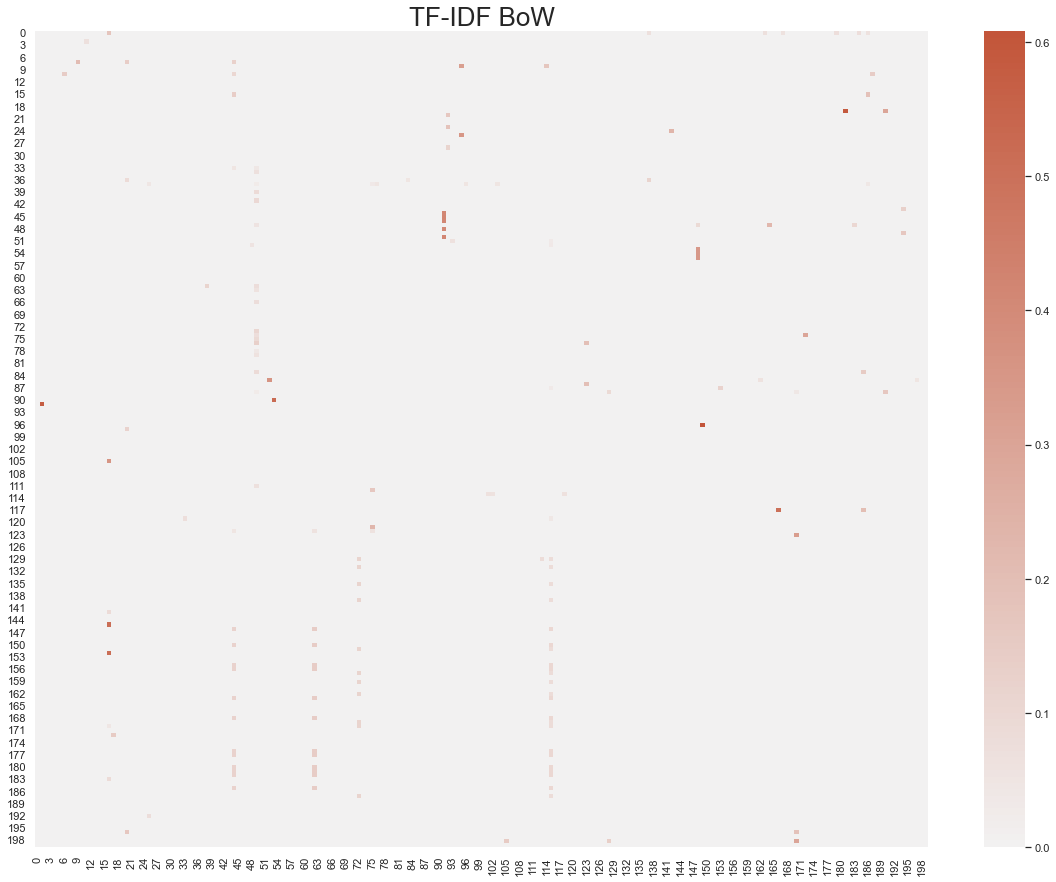

In [29]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(tfidf_bow.toarray()[:200,:200], center=0, cmap = sns.diverging_palette(230, 20, as_cmap=True))
plt.title('TF-IDF BoW', fontsize=26)
plt.show()

In [30]:
print(tuple(zip(sorted(set(df_corpus.iloc[0,1].split())), [count_bow.toarray()[0,cvect.vocabulary_[w]] for w in sorted(set(df_corpus.iloc[0,1].split()))])))

(('abstract', 4), ('amount', 1), ('ant', 1), ('anti', 1), ('apart', 1), ('apparance', 1), ('appeal', 1), ('attention', 1), ('beauty', 1), ('body', 1), ('bright', 2), ('bring', 1), ('close', 1), ('contemporary', 1), ('content', 1), ('create', 1), ('curtain', 11), ('designed', 1), ('dimension', 1), ('door', 5), ('draw', 2), ('duster', 1), ('elegance', 4), ('elegant', 2), ('enhances', 1), ('environment', 1), ('evening', 1), ('eyelet', 6), ('fabric', 1), ('filter', 1), ('first', 1), ('floral', 1), ('get', 1), ('give', 1), ('given', 1), ('good', 1), ('heart', 1), ('height', 2), ('high', 1), ('home', 2), ('interior', 1), ('joyous', 1), ('key', 1), ('length', 1), ('light', 1), ('look', 1), ('loving', 1), ('made', 1), ('make', 1), ('metal', 1), ('model', 2), ('modernistic', 1), ('moment', 1), ('morning', 2), ('multicolor', 4), ('name', 1), ('polyester', 6), ('print', 1), ('ray', 1), ('right', 1), ('ring', 1), ('romantic', 1), ('room', 2), ('shrinkage', 1), ('slide', 1), ('smoothly', 1), ('soft

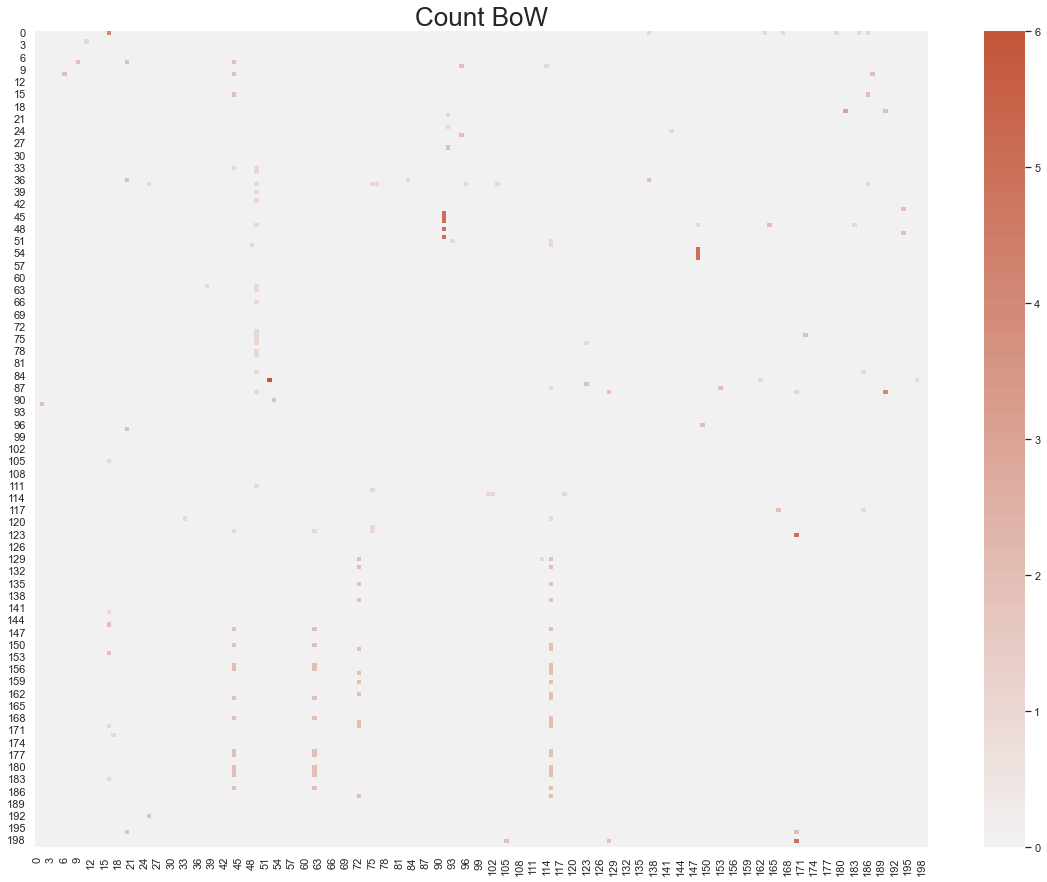

In [31]:
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(count_bow.toarray()[:200,:200], center=0, cmap = sns.diverging_palette(230, 20, as_cmap=True))
plt.title('Count BoW', fontsize=26)
plt.show()

# Topics Analysis

## LDA

In [32]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = len(set(categs))

print('n_topics:', n_topics)

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=30.,
        random_state=0)

# Fitter sur les données
lda.fit(tfidf_bow)

n_topics: 9


LatentDirichletAllocation(learning_method='online', learning_offset=30.0,
                          max_iter=5, n_components=9, random_state=0)

In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx), " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = n_topics
display_topics(lda, ctf.get_feature_names(), no_top_words)

Topic 0: laptop mug skin baby cotton multicolor print polyester towel
Topic 1: combo lipstick denver lowest edimax deodorant paris pizza honey
Topic 2: led bulb light usb best memory portable vrct airtel
Topic 3: watch men india discount great woman showpiece sonata dial
Topic 4: link combo intex dsl blush york playboy deo lowest
Topic 5: tew trendnet lgswatchessl digisol bgn hre compaq dru data
Topic 6: sticker vinyl wallmantra large uberlyfe medium extra best showpiece
Topic 7: tenda combo kadhai yardley archies adidas kalash best rose
Topic 8: router wireless asus wild band dual combo stone modem


c:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


## NMF

In [34]:
from sklearn.decomposition import NMF

# Run NMF
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd')
nmf.fit(tfidf_bow)

no_top_words = n_topics
display_topics(nmf, ctf.get_feature_names(), no_top_words)


Topic 0: watch men discount india great sonata woman dial strap
Topic 1: mug coffee ceramic perfect prithish tea printland one gift
Topic 2: baby girl fabric dress cotton boy sleeve neck shirt
Topic 3: rockmantra mug ceramic thrilling crafting porcelain permanent ensuring stay
Topic 4: abstract blanket double single quilt comforter raymond multicolor floral
Topic 5: laptop battery cell pavilion lapguard skin mouse pad shape
Topic 6: towel cotton bath soft hand face terry nkp absorbent
Topic 7: usb light led hub portable power flexible port fan
Topic 8: combo denver archies yardley nike playboy skin rose deo


c:\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(
c:\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Clustering

In [35]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features, y) :
    time1 = time.time()
    num_labels=len(set(y))
    tsne = TSNE(n_components=2, perplexity=10, n_iter=2000, learning_rate=200, init='random', random_state=0)
    X_tsne = tsne.fit_transform(features)

    n=min(len(y), len(X_tsne))
    X_tsne = X_tsne[:n, :]
    y = y[:n]
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, init='k-means++', n_init=100, random_state=0)
    cls.fit(X_tsne)    
    
    ARI = np.round(metrics.adjusted_rand_score(y, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_, time2


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y, labels, ARI, time, model_name, Scores) :
    n=min(len(y), len(labels))
    X_tsne = X_tsne[:n, :]
    y = y[:n]
    labels = labels[:n]

    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y, cmap='Set1', s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(set(y)), loc="best", title="Categorie")
    plt.title('Catégories Réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1', s=10)
    ax.legend(handles=scatter.legend_elements()[0], labels=list(set(labels)), loc="best", title="Clusters")
    plt.title('Clusters')
    
    plt.show()

    # Sauvgarder les scores
    stop = False
    try:
        if Scores == None:
            stop = True
    except:
        pass
    if not stop:
        # Evaluatation
        i = len(Scores)
        Scores.loc[i, 'Model'] = model_name
        Scores.loc[i, 'ARI'] = ARI
        Scores.loc[i, 'Time(s)'] = time
        # Convertion de type
        Scores['ARI'] = Scores['ARI'].astype('float')

In [36]:
Scores = pd.DataFrame(columns=['Model', 'ARI', 'hue'], index=[])

## Bag-of-Words

### Count

ARI :  0.5023 time :  19.0


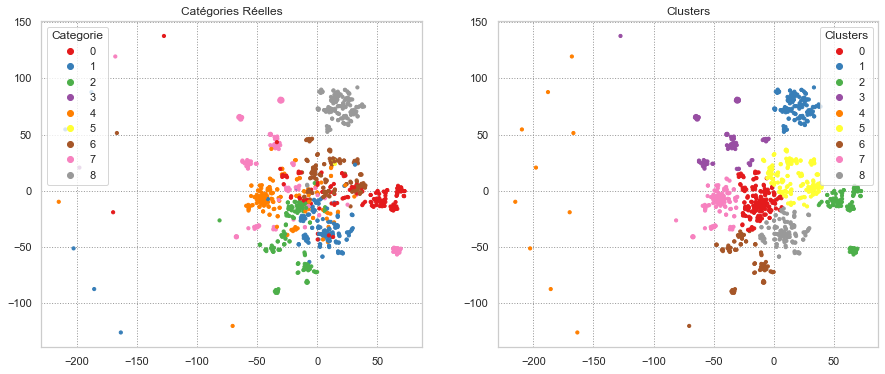

In [37]:
ARI, X_tsne, labels, _time = ARI_fct(count_bow, categs)
TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, 'Count', Scores)

### TF-IDF

ARI :  0.5582 time :  17.0


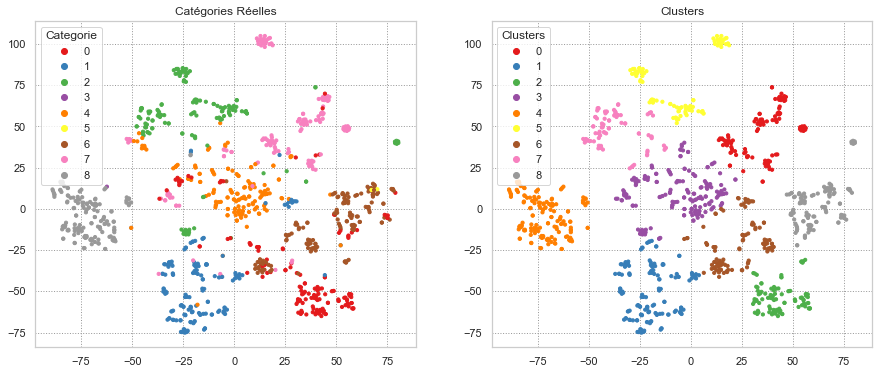

In [38]:
ARI, X_tsne, labels, _time = ARI_fct(tfidf_bow, categs)
TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, 'TF-IDF', Scores)

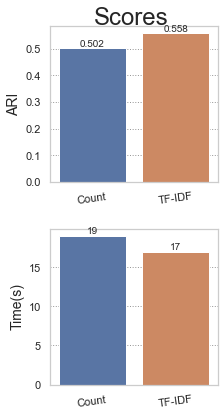

In [39]:
display_scores(Scores)

## Embeddings

### Gensim

In [40]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from multiprocessing import cpu_count
import gensim

sentences = df_corpus['description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [41]:
def gensim_embd(sentences, model='Word2Vec', size=250, maxlen = 30, window=5, min_count=1, epochs=100, verbose=True):
    # Création et entraînement du modèle FastText
    if verbose:
        print("Build & train FastText model ...")
    if model == 'FastText':
        model = gensim.models.FastText(min_count=min_count, window=window, vector_size=size, seed=0, workers=cpu_count())
    else:
        model = gensim.models.Word2Vec(min_count=min_count, window=window, vector_size=size, seed=0, workers=cpu_count())
    
    model.build_vocab(sentences)
    model.train(sentences, total_examples=model.corpus_count, epochs=epochs)
    model_vectors = model.wv
    words = model_vectors.index_to_key
    if verbose:
        print("Vocabulary size: %i" % len(words))
        print("FastText trained")


    # Préparation des sentences (tokenization)
        print("Fit Tokenizer ...")
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(sentences)
    x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                        maxlen=maxlen,
                                                        padding='post') 
                                                    
    num_words = len(tokenizer.word_index) + 1
    if verbose:
        print("Number of unique words: %i" % num_words)

    # Création de la matrice d'embedding
        print("Create Embedding matrix ...")
    word_index = tokenizer.word_index
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, size))
    i=0
    j=0
        
    for word, idx in word_index.items():
        i +=1
        if word in words:
            j +=1
            embedding_vector = model_vectors[word]
            if embedding_vector is not None:
                embedding_matrix[idx] = model_vectors[word]
                
    word_rate = np.round(j/i,4)
    if verbose:
        print("Word embedding rate : ", word_rate)
        print("Embedding matrix: %s" % str(embedding_matrix.shape))


    # Création du modèle
    word_input=Input(shape=(maxlen,),dtype='float64')  
    word_embedding=Embedding(input_dim=vocab_size,
                            output_dim=size,
                            weights = [embedding_matrix],
                            input_length=maxlen)(word_input)
    word_vec=GlobalAveragePooling1D()(word_embedding)  
    embed_model = Model([word_input],word_vec)

    if verbose:
        embed_model.summary()

    embeddings = embed_model.predict(x_sentences, workers=cpu_count(), use_multiprocessing=True)

    return ARI_fct(embeddings, categs) 

def gensim_embd_grid(Scores, sentences, model='Word2Vec', window=5, min_count=1, epochs=100, verbose=False):
    best_ARI = 0
    best_size = 0
    best_maxlen = 0
    best_X_tsne = None
    best_labels = None
    best_time = None

    for size in np.arange(50,1000, 20):
        for maxlen in np.arange(10,60, 5):
            print('==================== size=',size, ' maxlen=', maxlen, '====================')

            ARI, X_tsne, labels, _time = gensim_embd(sentences, model, size, maxlen, window, min_count, epochs, verbose)

            if ARI > best_ARI:
                best_ARI = ARI
                best_size = size
                best_maxlen = maxlen
                best_X_tsne = X_tsne
                best_labels = labels
                best_time = _time

    print('best_ARI=', best_ARI, 'best_size=', best_size, 'best_maxlen=', best_maxlen)
    TSNE_visu_fct(best_X_tsne, categs, best_labels, best_ARI, best_time, model, Scores)   

#### Word2Vec2

==================== size= 50  maxlen= 10 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.3555 time :  20.0
==================== size= 50  maxlen= 15 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4181 time :  20.0
==================== size= 50  maxlen= 20 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.3866 time :  19.0
==================== size= 50  maxlen= 25 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4238 time :  20.0
==================== size= 50  maxlen= 30 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.501 time :  20.0
==================== size= 50  maxlen= 35 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4916 time :  19.0
==================== size= 50  maxlen= 40 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.507 time :  19.0
=

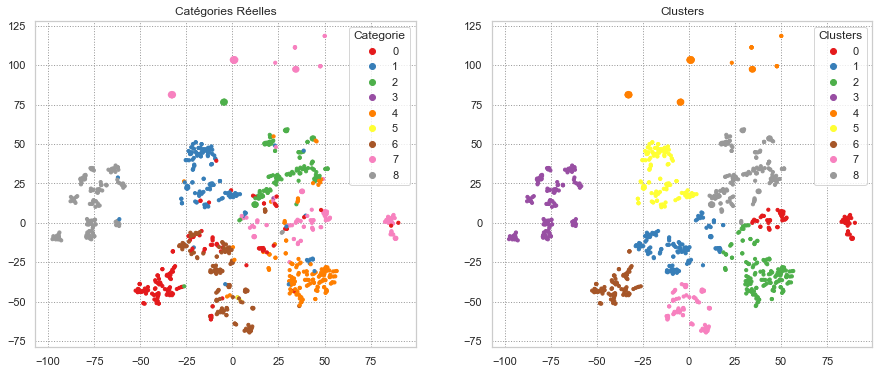

In [42]:
gensim_embd_grid(Scores, sentences)

#### FastText

In [42]:
gensim_embd_grid(Scores, sentences, 'FastText')

==================== size= 50  maxlen= 10 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.3327 time :  25.0
==================== size= 50  maxlen= 15 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4121 time :  20.0
==================== size= 50  maxlen= 20 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4716 time :  21.0
==================== size= 50  maxlen= 25 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.5177 time :  20.0
==================== size= 50  maxlen= 30 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.4195 time :  22.0
==================== size= 50  maxlen= 35 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.5176 time :  20.0
==================== size= 50  maxlen= 40 ====================
33/33 [==============================] - 0s 1ms/step
ARI :  0.5142 time :  19.0

## BERT

In [ ]:
from transformers import *
import tensorflow_hub as hub
import os
os.environ["TF_KERAS"]='1'

sentences = df_corpus['description'].to_list()
my_models = {}

In [ ]:
# Fonction de préparation des sentences
def inp_fct(model_type, sentences, tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    inp_tot = []

    for sent in sentences:
        inp = tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length' if 'gpt' not in model_type else False,
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(inp['input_ids'][0])
        token_type_ids.append(inp['token_type_ids'][0])
        attention_mask.append(inp['attention_mask'][0])
        inp_tot.append((inp['input_ids'][0], 
                             inp['token_type_ids'][0], 
                             inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, inp_tot
    

# Fonction de création des features
def feature_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, inp_tot = inp_fct(model_type, sentences[idx:idx+batch_size], 
                                                                      tokenizer, max_length)
        
        if mode=='HF' :    #  HuggingFace
            if 'distilbert' in model_type:
                outputs = model.predict([input_ids, attention_mask], batch_size=batch_size_pred)
            else:
                outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 }
            if 'distilbert' not in model_type:
                text_preprocessed["input_type_ids"] = token_type_ids
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features, last_hidden_states_tot

def compare(sentences, model_type, mode, max_length = 64, batch_size = 10, display=True, model_url=None, Scores = None):
    if mode + 'HF': #Hugging Face
        if model_type not in my_models:
            my_models[model_type] = TFAutoModel.from_pretrained(model_type)
        model = my_models[model_type]        
    if mode=='TFhub' : # Tensorflow Hub
        if model_url not in my_models:
            my_models[model_url] = hub.KerasLayer(model_url, trainable=True)
        model = my_models[model_url]
    features, last_hidden_states_tot = feature_fct(model, model_type, sentences, max_length, batch_size, mode=mode)

    ARI, X_tsne, labels, _time = ARI_fct(features, categs)
    if display:
        TSNE_visu_fct(X_tsne, categs, labels, ARI, _time, model_type, Scores)
    return ARI, X_tsne, labels, _time

def compare_grid(Scores, sentences, model_type, mode, model_url=None):
    best_max_length = 0
    best_batch_size = 0
    best_ARI = 0
    best_X_tsne = None
    best_labels = None
    best_time = None

    for max_length in range(20, 100+1, 5):
        for batch_size in range(5,30+1, 5):
            print('========================== max_length =', max_length, 'batch_size =', batch_size, '==========================')
            ARI, X_tsne, labels, _time = compare(sentences, model_type, mode, max_length, batch_size, display=False, model_url=model_url)

            if ARI > best_ARI:
                best_ARI = ARI
                best_max_length = max_length
                best_batch_size = batch_size
                best_X_tsne  = X_tsne
                best_labels = labels
                best_time = _time
    
    print('best_ARI=', best_ARI, 'best_batch_size=', best_batch_size, 'best_max_length=', best_max_length)
    TSNE_visu_fct(best_X_tsne, categs, best_labels, best_ARI, best_time, model_type, Scores)

### HuggingFace

#### Bert (basic)

In [ ]:
compare_grid(Scores, sentences, 'bert-base-uncased', 'HF')

========================== max_length = 20 batch_size = 5 ==========================
1/1 [==============================] - 0s 197ms/step
temps traitement :  63.0
ARI :  0.499 time :  22.0
========================== max_length = 20 batch_size = 10 ==========================
1/1 [==============================] - 0s 280ms/step


KeyboardInterrupt: 

#### RoBerta

1/1 [==============================] - 2s 2s/step
temps traitement :  252.0
ARI :  0.3074 time :  49.0


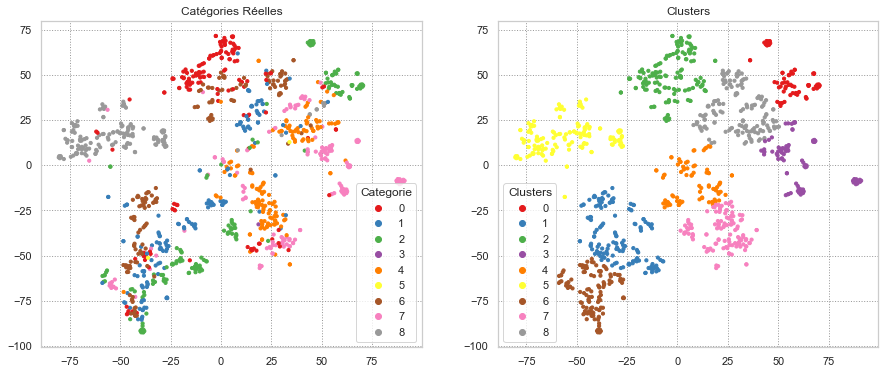

(0.3074,
 array([[ 32.936516,  47.660034],
        [ 10.089756,  46.27097 ],
        [ 11.517926,  43.504063],
        ...,
        [ 13.276611, -45.274654],
        [ 15.438989, -47.03189 ],
        [ 19.244879, -43.376133]], dtype=float32),
 array([8, 2, 2, ..., 7, 7, 7]))

In [ ]:
compare_grid(Scores, sentences, 'roberta-base', 'HF')

#### DistilBert

1/1 [==============================] - 0s 378ms/step
temps traitement :  51.0
ARI :  0.4 time :  22.0


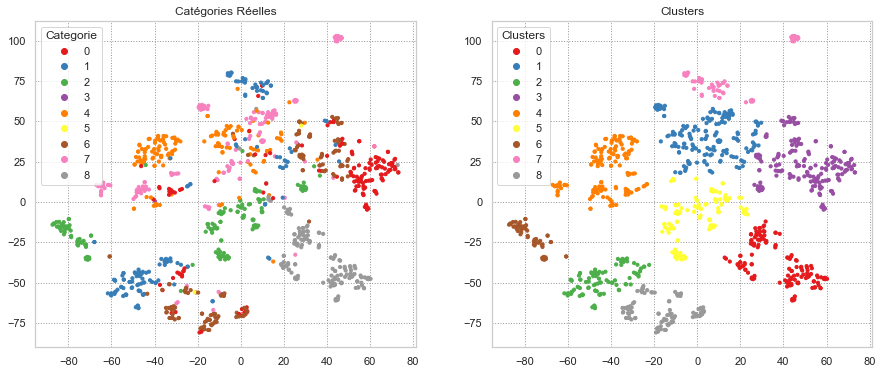

(0.4,
 array([[ 24.980556 ,  32.181698 ],
        [ 43.082245 ,  49.553185 ],
        [ 43.328716 ,  51.15696  ],
        ...,
        [-33.23619  ,   8.127689 ],
        [-32.611504 ,   5.7790303],
        [-32.23312  ,   7.2757936]], dtype=float32),
 array([1, 3, 3, ..., 4, 4, 4]),
 22.0)

In [ ]:
compare_grid(Scores, sentences, 'distilbert-base-uncased', 'HF')

### TensorFlow Hub

#### Bert (basic)

In [ ]:
compare_grid(Scores, sentences, 'bert-base-uncased', 'TFhub', model_url='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

========================== max_length = 20 batch_size = 5 ==========================
temps traitement :  53.0
ARI :  0.5017 time :  22.0
========================== max_length = 20 batch_size = 10 ==========================


KeyboardInterrupt: 

#### RoBerta

temps traitement :  240.0
ARI :  0.3194 time :  51.0


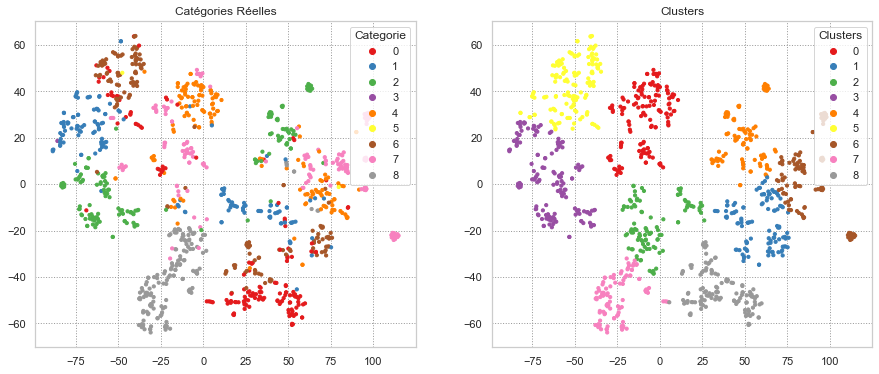

(0.3194,
 array([[ 73.85226  , -26.815985 ],
        [ 49.445015 , -31.678476 ],
        [ 50.00787  , -27.739006 ],
        ...,
        [-25.443321 ,   4.0347214],
        [-23.968979 ,   6.0945554],
        [-26.78043  ,   6.6379194]], dtype=float32),
 array([1, 1, 1, ..., 0, 0, 0]))

In [ ]:
compare_grid(Scores, sentences, 'roberta-base', 'TFhub', model_url='https://tfhub.dev/jeongukjae/roberta_en_cased_L-12_H-768_A-12/1')

#### DistilBert

temps traitement :  47.0
ARI :  0.3965 time :  22.0


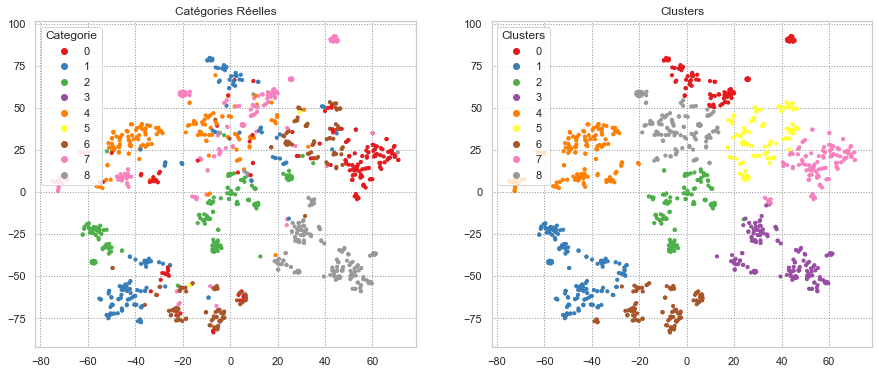

(0.3965,
 array([[ 22.355083 ,  33.47516  ],
        [ 42.73913  ,  50.20602  ],
        [ 42.95763  ,  51.77184  ],
        ...,
        [-30.47919  ,   5.7976847],
        [-32.704414 ,   6.867027 ],
        [-31.150028 ,   7.0811405]], dtype=float32),
 array([5, 5, 5, ..., 4, 4, 4]),
 22.0)

In [ ]:
compare_grid(Scores, sentences, 'distilbert-base-uncased', 'TFhub', model_url='https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1')

## GPT

### GPT2

In [ ]:
compare('gpt2')

C:\Users\Shadow\AppData\Local\Temp/ipykernel_26528/1754053377.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_ids = np.asarray(input_ids)
C:\Users\Shadow\AppData\Local\Temp/ipykernel_26528/1754053377.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  token_type_ids = np.asarray(token_type_ids)
C:\Users\Shadow\AppData\Local\Temp/ipykernel_26528/1754053377.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecate

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).

### DistilGPT2

In [ ]:
compare('distilgpt2')

Downloading: 100%|██████████| 762/762 [00:00<00:00, 139kB/s]
Downloading: 100%|██████████| 313M/313M [00:21<00:00, 14.9MB/s] 
Downloading: 100%|██████████| 0.99M/0.99M [00:01<00:00, 726kB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 655kB/s] 
Downloading: 100%|██████████| 1.29M/1.29M [00:01<00:00, 710kB/s]
Using pad_token, but it is not set yet.


ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)` or add a new pad token via `tokenizer.add_special_tokens({'pad_token': '[PAD]'})`.